In [106]:
# Import modules

import os
import pandas as pd
import numpy as np
import scipy.stats as sp
import datetime
import seaborn as sns
from datetime import date, timedelta
from matplotlib import pyplot as plt
from scipy.stats import skew

sns.set_style(style='whitegrid')
sns.set_palette(palette='colorblind')

In [107]:
# Petter's code for extracting all the data files and then combining them.

def extract_folder(folderpath, add_scores=False, downsample=None):
    """
    Extract CSV data from folder and subfolders into a dataframe.

    Args:
      folderpath (str): Path to the folder containing CSV files.
      add_scores (bool, optional): Boolean to add scores.csv to the dataframe. Defaults to False.
      downsample (int, optional): Number of rows to downsample CSVs to. Defaults to None.

    Returns:
      pandas.DataFrame: DataFrame of concatenated CSV data.
    """
    import os
    import pandas as pd
    
    # Dict to store dataframes by condition  
    dfs = {'control': [], 'condition': []}

    try:
        # Handle top-level scores CSV
        if add_scores and 'scores.csv' in os.listdir(folderpath):
            scores_path = os.path.join(folderpath, 'scores.csv')  
            dfs['scores'] = pd.read_csv(scores_path)

        # Get subfolders
        subfolders = [f for f in os.listdir(folderpath) if os.path.isdir(os.path.join(folderpath, f))]

        for subfolder in subfolders:
            subfolderpath = os.path.join(folderpath, subfolder)  

            # Get list of CSV files
            files = os.listdir(subfolderpath)

            for file in files:
                filepath = os.path.join(subfolderpath, file)

                # Extract ID from filename 
                id = file.split('.')[0]

                df = pd.read_csv(filepath)

                # Downsample if needed
                if downsample:
                    df = df.sample(downsample)

                # Add ID column - this is the filename without the extension
                df['id'] = id

                # Add 'condition' column
                df['condition'] = subfolder

                # Convert 'timestamp' and 'date' to datetime
                df['timestamp'] = pd.to_datetime(df['timestamp'])
                df['date'] = pd.to_datetime(df['date'])

                # Append to dict by condition
                if subfolder == 'control':
                    dfs['control'].append(df)
                else:  
                    dfs['condition'].append(df)

    except OSError:
        print(f"Error reading folder: {folderpath}")

    # concatenate dfs for each condition
    dfs['control'] = pd.concat(dfs['control'])
    dfs['condition'] = pd.concat(dfs['condition'])

    # Reset index on the final df
    df = pd.concat([dfs['control'], dfs['condition']]).reset_index(drop=True)

    # add label column
    df['label'] = 0
    df.loc[df['condition'] == 'condition', 'label'] = 1
    
    # remove old 'condition' column
    df.drop('condition', axis=1, inplace=True)

    # Final concat
    return df

In [108]:
# Extration of all the acitvity data into one data frame

df = extract_folder('../data/depresjon')
df.shape


(1571706, 5)

In [109]:
# Function to clasify each row of data as either day (0) or night (1) 

def day_or_night (dataframe,day_start,day_end):
    
    # day night classifying function
    def day_night_test(time):
        if day_start <= time.hour < day_end:
            return (0)
        else:
            return (1)
    
    # Create a copy of the data frame
    dayNight_df = dataframe.copy()
    
    # Add in the new column with day or night values
    dayNight_df['day_night'] = dayNight_df['timestamp'].apply(day_night_test)
    return (dayNight_df)

# Day values using rodriguez model values of 8:00 - 20:00. 

DN_df = day_or_night(df,8,20)

In [110]:
# Function to create a field of acitve (1) and non-active (0) time

def active_nonactive (dataframe):
    
    # function to test if a minute is active ('1') or inactive('0')
    def time_test(activity):
        if activity < 5:
            return ('0')
        else:
            return ('1') 
    
    # Create a copy of the data frame    
    new_df = dataframe.copy()
    
    # Create a new column classifying each minute as acitve or inactive
    new_df['col1'] = new_df['activity'].apply(time_test)
    
    # Create a new column that sums the 11 values (5 below and 5 above) the trigger value 
    new_df['col2'] = new_df['col1'].rolling(window=11, center=True).sum()
    
    # Function to test if a period is active or inactive
    def activ_test(value):
        if value >= 2:
            return (1)    
        elif value < 2:
            return (0)
        else:
            return ('NaN')
        
    # Create the column of active or inactive periods   
    new_df['active_inactive'] = new_df['col2'].apply(activ_test)
    
    # Drop the unnecessary columns created
    new_df.drop(['col1','col2'], axis=1, inplace=True)
    
    return(new_df)

active_df = active_nonactive(DN_df)

In [111]:
# Read in sunlight data obtain from the website
# Sunrise and sunset by month for Oslo 
# 'https://www.worlddata.info/europe/norway/sunset.php'

sunlight = pd.read_csv('data/depresjon/Norway_Sunlight.csv')

# add month column for merging 
active_df['month'] = pd.to_datetime(active_df['timestamp']).dt.month

# merge dataframes
merged_df = active_df.copy()
merged_df = pd.merge(merged_df, sunlight, on='month', how='inner')

# remove unnecessary columns       
merged_df.drop('month', axis=1, inplace=True)

In [112]:
# Function to clasify each row of data as either light (0) or dark (1) 

def light_dark(dataframe):
    
    # extract time, sunrise and sunset columns 
    # convert sunrise and sunset columns to time format        
    dataframe['time'] = pd.to_datetime(dataframe['timestamp']).dt.time
    sunrise = pd.to_datetime(dataframe['sunrise']).dt.time
    sunset = pd.to_datetime(dataframe['sunset']).dt.time
    time = dataframe['time']
        
    # create a list of when it is light(0) or dark(1)
    size = len(sunrise)
    light_dark = []
    for n in range (0,size):
        if sunrise[n] <= time[n] < sunset[n]:
            light_dark.append(0)
        else:
            light_dark.append(1)

    # add list as a new column 'light_dark' to dataframe    
    dataframe['light_dark'] = light_dark

    # remove unnecessary columns       
    dataframe.drop(['time','sunrise','sunset'], axis=1, inplace=True)
    
    return(dataframe)
    

LD_df = light_dark(merged_df)

C:\Users\44778\AppData\Local\Temp\ipykernel_24332\1526019979.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sunrise = pd.to_datetime(dataframe['sunrise']).dt.time
C:\Users\44778\AppData\Local\Temp\ipykernel_24332\1526019979.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sunset = pd.to_datetime(dataframe['sunset']).dt.time


In [113]:
# Function to extract only the full days

def fullDays(dataframe):
    
    # Make a list of the particpants
    participants = dataframe['id'].unique()
    df_new = pd.DataFrame({})
    
    # Iterate through each participant creating subsets
    for participant in participants:       
        df_tochange = dataframe[dataframe['id'] == participant]
        
        # Identify min timestamps and date for comparison
        min_timestamp = df_tochange['timestamp'].min()
        min_date = df_tochange['date'].min()
        
        # Assign the starting date and time
        if min_date < min_timestamp:
            min_fullday_date = min_date + timedelta(1)
            df_minchange = df_tochange[df_tochange['date'] >= min_fullday_date]
        else:
            df_minchange = df_tochange.copy()
        
        # Identify max timestamps and date for comparison        
        max_timestamp = df_minchange['timestamp'].max()
        max_date = df_minchange['date'].max()
        
        # Assign the ending date and time
        if max_date < max_timestamp:
            df_maxchange = df_minchange[df_minchange['date'] < max_date]
        else:
            df_maxchange = df_minchange.copy()
        
        # combine all subsets
        df_new = pd.concat([df_new,df_maxchange])
        
    return (df_new)

fulldays_df = fullDays(LD_df)

In [114]:
# Read in the scores data
scores = pd.read_csv('data/depresjon/scores.csv')

# Function to match the amount of data to the number of days given in the scores dataset
def trueDates (dataframe):
    
    # Create a blank dataframe
    df_new = pd.DataFrame({})
    
    # Make a list of all participants
    participants = dataframe['id'].unique()
    
    # Iterate through each participant creating subsets
    for participant in participants:
        df_tochange = dataframe[dataframe['id'] == participant]
        
        # Identify the true number of days on the scores dataset
        trueDays = scores.loc[scores['number'] == participant, 'days'].values[0]
        
        # Assign min date and calcualte max date
        min_date = dataframe.loc[dataframe['id'] == participant, 'date'].min()
        max_truedate = min_date + timedelta(int(trueDays))
        
        # reduce the data set to match the true dates
        df_reduce = df_tochange[df_tochange['date'] < max_truedate]
        
        # combine the dataframes
        df_new = pd.concat([df_new,df_reduce])
    
    return (df_new)

TD_df = trueDates(fulldays_df)

## We decided to limit the data further to only full week

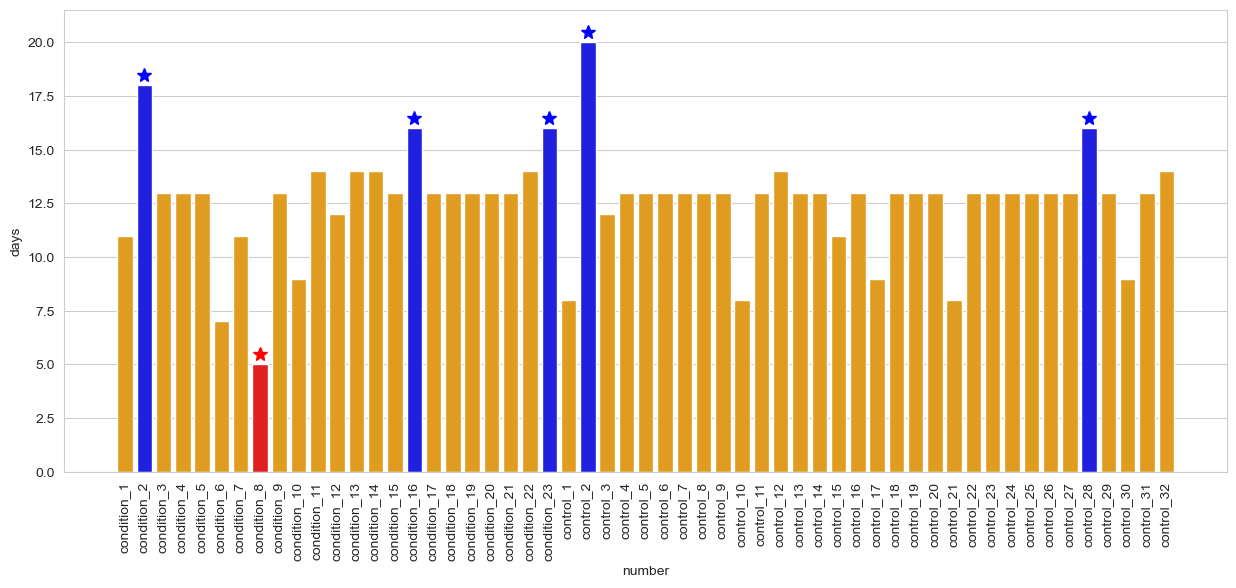

In [115]:
# Plot to show the number of days

plt.figure(figsize=(15, 6))

palette = ['red' if condition == 'condition_8' 
           else 'blue' if condition in ['condition_16','condition_23','condition_2', 'control_2', 'control_28'] 
           else 'orange' for condition in scores['number']]

ax = sns.barplot(data=scores, x='number', y='days',color='blue',palette=palette)
plt.xticks(rotation=90)



ax.plot(7,5.5,"*", markersize=10, color="r")
ax.plot(1,18.5,"*", markersize=10, color="b")
ax.plot(24,20.5,"*", markersize=10, color="b")
ax.plot(50,16.5,"*", markersize=10, color="b")
ax.plot(15,16.5,"*", markersize=10, color="b")
ax.plot(22,16.5,"*", markersize=10, color="b")

plt.show()

In [116]:
def weekDays(dataframe):
    
    participants = dataframe['id'].unique()
    df_new = pd.DataFrame({})
    
    for participant in participants:
        
        df_tochange = dataframe[dataframe['id'] == participant]
        
        min_date = pd.to_datetime(df_tochange['date']).min()
        max_date = pd.to_datetime(df_tochange['date']).max()
        week = min_date + timedelta(7)   
        
        days_difference = (max_date - min_date).days
        if days_difference > 14:
            week = min_date + timedelta(14) 
        else:
            week = min_date + timedelta(7) 
        
        df_week = df_tochange[df_tochange['date'] < week]
                        
        df_new = pd.concat([df_new,df_week])
        
    return (df_new)

week_df = weekDays(TD_df)




In [117]:
clean_df = week_df[week_df['id'] != "condition_8"]

In [118]:
clean_df.isnull().sum()

timestamp          0
date               0
activity           0
id                 0
label              0
day_night          0
active_inactive    0
light_dark         0
dtype: int64

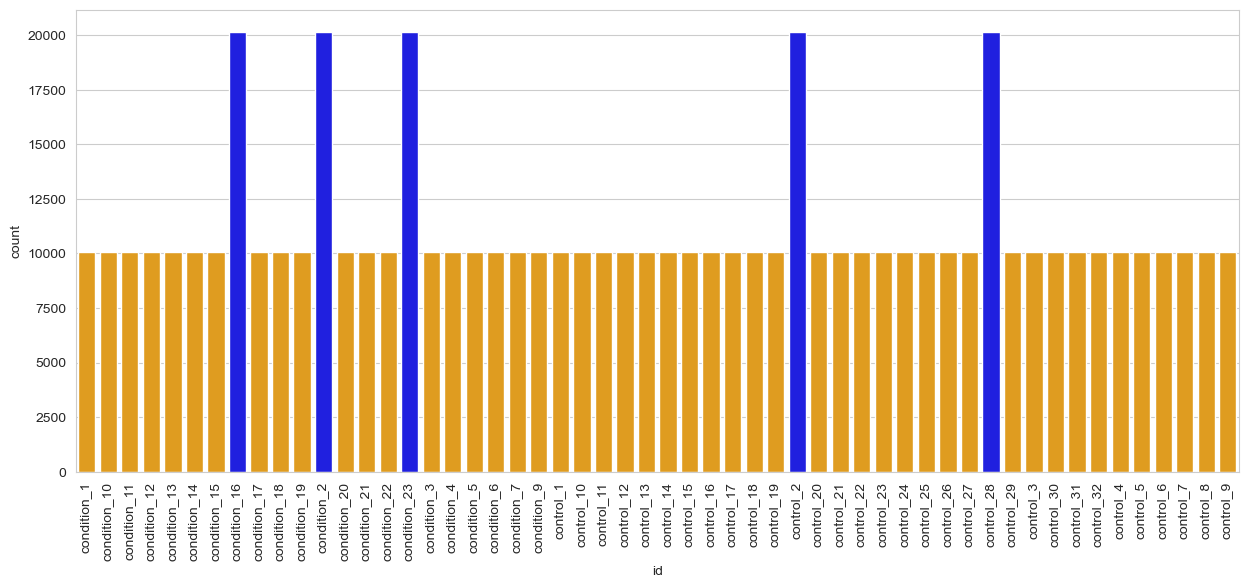

In [119]:
WD_df = clean_df.groupby('id').size().reset_index(name='count')

plt.figure(figsize=(15, 6))

palette = ['red' if condition == 'condition_8' 
           else 'blue' if condition in ['condition_16','condition_23','condition_2', 'control_2', 'control_28'] 
           else 'orange' for condition in WD_df['id']]

sns.barplot(data=WD_df, x='id', y='count',color='blue', palette=palette)
plt.xticks(rotation=90)
plt.show()

In [120]:
# Add the day column
clean_df['day']=pd.to_datetime(clean_df['timestamp']).dt.day

# Rename the number column to "id" matching the data frames title
scores.rename(columns={'number':'id'}, inplace=True)

# merge data frames to add the gender column
merged_df = pd.merge(clean_df, scores, on='id')

# remove unused columns
merged_df.drop(['days','age','afftype','melanch','inpatient','edu','marriage','work','madrs1','madrs2'], axis=1, inplace=True)

C:\Users\44778\AppData\Local\Temp\ipykernel_24332\2449371429.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['day']=pd.to_datetime(clean_df['timestamp']).dt.day


In [121]:
def Percentzero (values):
    zeros = (values == 0).sum().sum()
    total_values = values.size
    return zeros / total_values * 100

# create a function to produce a table of features listed above

def extract_features(dataframe):
    
    # Group by 'id' and 'label' columns
    grouped = dataframe.groupby(['id', 'label','gender','day'])['activity']

    # Calculate statistics for 'standardised_activity' within each group
    features1_df = pd.DataFrame({
        'mean' : grouped.mean(),
        'std' : grouped.std(),
        '%zero': grouped.apply(Percentzero),
        'kurtosis': grouped.apply(lambda x: sp.kurtosis(x, fisher=False))
    })

    return features1_df
    
features1 = extract_features(merged_df).reset_index()

In [122]:
# Function to find percentage activity at night/day/light/dark

def activeAtNight (dataframe):
    
    dataframe['day_id']= dataframe['id'].astype(str) + "-" + dataframe['day'].astype(str)
    
    # Create a new empty dataframe
    df_ndld = pd.DataFrame({})
    
    # Create a list of participants
    participants = dataframe['day_id'].unique()

    # List for storing values
    participantList = []
    dayList = []
    activeNightList = []
    inactiveDayList = []
    activeDarkList = []
    inactiveLightList = []
    
    
    # Create a subset of the df for each participant
    for participant in participants:
        
        df_tochange = dataframe[dataframe['day_id'] == participant]
        
        inactive_day = len(df_tochange[(df_tochange['day_night'] == 0) & (df_tochange['active_inactive'] == 0)])
        active_night = len(df_tochange[(df_tochange['day_night'] == 1) & (df_tochange['active_inactive'] == 1)])
        night = len(df_tochange[(df_tochange['day_night'] == 1)])
        day = len(df_tochange[(df_tochange['day_night'] == 0)])
        
        inactive_light = len(df_tochange[(df_tochange['light_dark'] == 0) & (df_tochange['active_inactive'] == 0)])
        active_dark = len(df_tochange[(df_tochange['light_dark'] == 1) & (df_tochange['active_inactive'] == 1)])
        dark = len(df_tochange[(df_tochange['light_dark'] == 1)])
        light = len(df_tochange[(df_tochange['light_dark'] == 0)])        
        
        participantList.append(participant)
        dayList.append(day)
        activeNightList.append(active_night/night)
        inactiveDayList.append(inactive_day/day)
        activeDarkList.append(active_dark/dark)
        inactiveLightList.append(inactive_light/light)
            
    
    df_ndld['day_id'] = participantList
    df_ndld['day'] = dayList
    df_ndld['activeNight'] = activeNightList
    df_ndld['inactiveDay'] = inactiveDayList
    df_ndld['activeDark'] = activeDarkList
    df_ndld['inactiveLight'] = inactiveLightList
    
    df_ndld[['id', 'day']] = df_ndld['day_id'].str.split('-', expand=True)
    df_ndld.drop('day_id', axis=1 , inplace=True)
    df_ndld['day'] = df_ndld['day'].astype(int)        
    return(df_ndld)

AN = activeAtNight(merged_df)

In [123]:
features_full = pd.merge(AN, features1, on=['id','day'], how='inner')

In [124]:
features_full

,day,activeNight,inactiveDay,activeDark,inactiveLight,id,label,gender,mean,std,%zero,kurtosis
0,19,0.583333,0.027778,0.657967,0.099719,control_1,0,2,185.568056,346.555786,38.680556,16.792497
1,20,0.645833,0.041667,0.664835,0.057584,control_1,0,2,225.981250,384.378661,35.833333,8.981030
2,21,0.516667,0.125000,0.575549,0.181180,control_1,0,2,169.663194,304.317895,45.625000,11.216640
3,22,0.590278,0.051389,0.686813,0.146067,control_1,0,2,183.690972,277.006551,36.111111,12.226471
4,23,1.000000,0.000000,1.000000,0.000000,control_1,0,2,347.075000,236.845868,2.361111,10.741366
...,...,...,...,...,...,...,...,...,...,...,...,...
408,15,0.731944,0.050000,0.725490,0.127866,condition_5,1,2,139.443056,230.621545,35.277778,14.206414
409,16,0.593056,0.147222,0.562092,0.233686,condition_5,1,2,135.969444,259.973544,45.208333,20.453804
410,17,0.686111,0.162500,0.735294,0.231041,condition_5,1,2,146.593056,245.481979,39.513889,9.365841
411,18,0.826389,0.163889,0.983660,0.209877,condition_5,1,2,152.128472,263.493448,33.472222,12.793927


In [125]:
features_full = features_full.reindex(columns=['id','gender','label','mean','std','%zero', 'activeNight', 'inactiveDay',
       'activeDark', 'inactiveLight'])

In [126]:
features_full

,id,gender,label,mean,std,%zero,activeNight,inactiveDay,activeDark,inactiveLight
0,control_1,2,0,185.568056,346.555786,38.680556,0.583333,0.027778,0.657967,0.099719
1,control_1,2,0,225.981250,384.378661,35.833333,0.645833,0.041667,0.664835,0.057584
2,control_1,2,0,169.663194,304.317895,45.625000,0.516667,0.125000,0.575549,0.181180
3,control_1,2,0,183.690972,277.006551,36.111111,0.590278,0.051389,0.686813,0.146067
4,control_1,2,0,347.075000,236.845868,2.361111,1.000000,0.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
408,condition_5,2,1,139.443056,230.621545,35.277778,0.731944,0.050000,0.725490,0.127866
409,condition_5,2,1,135.969444,259.973544,45.208333,0.593056,0.147222,0.562092,0.233686
410,condition_5,2,1,146.593056,245.481979,39.513889,0.686111,0.162500,0.735294,0.231041
411,condition_5,2,1,152.128472,263.493448,33.472222,0.826389,0.163889,0.983660,0.209877


In [127]:
male_features = features_full[features_full['gender'] == 2] 
female_features = features_full[features_full['gender'] == 1] 

In [128]:
male_features.drop('gender', axis=1, inplace=True)
male_features

C:\Users\44778\AppData\Local\Temp\ipykernel_24332\508055293.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  male_features.drop('gender', axis=1, inplace=True)


,id,label,mean,std,%zero,activeNight,inactiveDay,activeDark,inactiveLight
0,control_1,0,185.568056,346.555786,38.680556,0.583333,0.027778,0.657967,0.099719
1,control_1,0,225.981250,384.378661,35.833333,0.645833,0.041667,0.664835,0.057584
2,control_1,0,169.663194,304.317895,45.625000,0.516667,0.125000,0.575549,0.181180
3,control_1,0,183.690972,277.006551,36.111111,0.590278,0.051389,0.686813,0.146067
4,control_1,0,347.075000,236.845868,2.361111,1.000000,0.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...
408,condition_5,1,139.443056,230.621545,35.277778,0.731944,0.050000,0.725490,0.127866
409,condition_5,1,135.969444,259.973544,45.208333,0.593056,0.147222,0.562092,0.233686
410,condition_5,1,146.593056,245.481979,39.513889,0.686111,0.162500,0.735294,0.231041
411,condition_5,1,152.128472,263.493448,33.472222,0.826389,0.163889,0.983660,0.209877


In [129]:
female_features.drop('gender', axis=1, inplace=True)
female_features

C:\Users\44778\AppData\Local\Temp\ipykernel_24332\1324321056.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  female_features.drop('gender', axis=1, inplace=True)


,id,label,mean,std,%zero,activeNight,inactiveDay,activeDark,inactiveLight
7,control_22,0,250.240972,364.285693,0.138889,0.711111,0.002778,0.764972,0.003604
8,control_22,0,226.442361,324.127886,0.000000,0.677778,0.006944,0.732203,0.000000
9,control_22,0,283.729167,403.716777,0.000000,0.712500,0.015278,0.753672,0.000000
10,control_22,0,229.722917,378.504264,0.000000,0.715278,0.106944,0.776271,0.151351
11,control_22,0,286.948611,467.199972,0.000000,0.840278,0.115278,0.877966,0.162162
...,...,...,...,...,...,...,...,...,...
394,condition_23,1,276.040972,371.917925,39.236111,0.613889,0.115278,0.575163,0.203704
395,condition_23,1,280.824306,375.140399,32.013889,0.606944,0.000000,0.620915,0.147266
396,condition_23,1,297.122917,473.886151,44.930556,0.608333,0.115278,0.568627,0.205467
397,condition_23,1,234.704861,374.687294,45.000000,0.625000,0.098611,0.709150,0.222222


In [198]:
female_features1 = female_features.copy()
female_features1.drop(['%zero','activeNight','inactiveDay'], axis=1, inplace=True)
male_features1 = male_features.copy()
male_features1.drop(['%zero','activeNight','inactiveDay'], axis=1, inplace=True)

In [199]:
male_features.to_csv('male_features.csv', index=False)
female_features.to_csv('female_features.csv', index=False)
male_features1.to_csv('male_features_less.csv', index=False)
female_features1.to_csv('female_features_less.csv', index=False)

In [131]:
# Load ML modules

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import random


In [132]:
male_features

,id,label,mean,std,%zero,activeNight,inactiveDay,activeDark,inactiveLight
0,control_1,0,185.568056,346.555786,38.680556,0.583333,0.027778,0.657967,0.099719
1,control_1,0,225.981250,384.378661,35.833333,0.645833,0.041667,0.664835,0.057584
2,control_1,0,169.663194,304.317895,45.625000,0.516667,0.125000,0.575549,0.181180
3,control_1,0,183.690972,277.006551,36.111111,0.590278,0.051389,0.686813,0.146067
4,control_1,0,347.075000,236.845868,2.361111,1.000000,0.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...
408,condition_5,1,139.443056,230.621545,35.277778,0.731944,0.050000,0.725490,0.127866
409,condition_5,1,135.969444,259.973544,45.208333,0.593056,0.147222,0.562092,0.233686
410,condition_5,1,146.593056,245.481979,39.513889,0.686111,0.162500,0.735294,0.231041
411,condition_5,1,152.128472,263.493448,33.472222,0.826389,0.163889,0.983660,0.209877


In [173]:
# Function for randomly splitting a column in the data frame
# in the ratio 1:n

def pick_ran_ids(dataframe,n,split_column):    
    idList = list(dataframe[split_column].unique())
    size = len(idList)
    random.shuffle(idList)
    testList = idList[:int(size*n):]
    trainList = idList[int(size*n):]
    return(testList,trainList)

# Function for splitting a dataframe using the list generated above

def split (dataframe,list):

    # Create a blank dataframe
    df_new = pd.DataFrame({})

    for l in list:
        df_toAdd = dataframe[dataframe['id'] == l]
        df_new = pd.concat([df_new,df_toAdd])
    return (df_new)


# Function for splitting a dataframe into train and test by a specific column

def improved_train_test_split(dataframe,n,split_column,result_column):
    
    listA, listB = pick_ran_ids(dataframe,n,split_column)
    
    Test = split(dataframe,listA)
    Train = split(dataframe,listB)
    
    y_train = Train[result_column]
    y_test = Test[result_column]
    
    X_test = Test.copy()
    X_train = Train.copy()
     
    X_test.drop([split_column,result_column],axis=1, inplace=True)
    X_train.drop([split_column,result_column],axis=1, inplace=True)
    
    return(X_train,X_test,y_train,y_test)


In [179]:
# Split data into train and test sets by the 'id' column

XM_train,XM_test,yM_train,yM_test = improved_train_test_split(male_features,0.3,'id','label')
XF_train,XF_test,yF_train,yF_test = improved_train_test_split(female_features,0.3,'id','label')

In [180]:
trainTestList = [XM_train, XM_test, yM_train, yM_test, XF_train, XF_test, yF_train, yF_test]

In [182]:
# Min-max scaling

def min_max_scale(dataframe):
    
    col_list = dataframe.columns
    
    df = dataframe.copy()
    
    for col in col_list:
        Xmin = df[col].min()
        Xmax = df[col].max()    
        
        if Xmax-Xmin > 0:
            df[col] = (df[col]-Xmin)/(Xmax-Xmin)
        
    return (df)

In [183]:
def print_metrics(pred,test):
    
    # Calculate True Positives, True Negatives, False Positives, False Negatives
    true_positive = ((pred == 1) & (test == 1)).sum()
    true_negative = ((pred == 0) & (test == 0)).sum()
    false_positive = ((pred == 1) & (test == 0)).sum()
    false_negative = ((pred == 0) & (test == 1)).sum()

    # Calculate additional metrics
    if true_positive + false_negative == 0:
        sensitivity = "NaN"
    else:
        sensitivity = true_positive / (true_positive + false_negative)
    
    if true_negative + false_positive == 0:
        specificity = "NaN"
    else:
        specificity = true_negative / (true_negative + false_positive)

    if true_positive + false_positive == 0:
        ppv = "NaN"
    else:
        ppv = true_positive / (true_positive + false_positive)
    
    if true_negative + false_negative == 0:
        npv = "NaN"
    else:
        npv = true_negative / (true_negative + false_negative)
    
    if true_positive + true_negative + false_positive + false_negative == 0:
        accuracy = "NaN"
    else:
        accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
        

    # Create a DataFrame
    results_df = pd.DataFrame({
        'Metric': ['Accuracy', 'True Positive','True Negative', 'False Positive', 'False Negative', 
                   'Sensitivity', 'Specificity', 'Predictive Value (PPV)', 
                   'Negative Predicted Value'],
        'Value': [accuracy, true_positive, true_negative, false_positive, false_negative, 
                  sensitivity, specificity, ppv, npv]
    })

    # Display the DataFrame
    print(results_df)

In [188]:
def run_ml_algorithms(dataframe,n,split_column,result_column,color):
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = improved_train_test_split(dataframe,n,split_column,result_column)

    # Normalise the data
    X_train = min_max_scale(X_train)
    X_test = min_max_scale(X_test)
           
    # Initialize classifiers
    classifiers = {
        'KNN': KNeighborsClassifier(),
        'RF': RandomForestClassifier(),
        'Decision Tree': DecisionTreeClassifier(),
        'Naive Bayes': GaussianNB(),
        'Logistic Regression': LogisticRegression(),
        'SVM': SVC()
    }

    results = {}

    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)  # Train the model
        y_pred = clf.predict(X_test)  # Predict on test data

        
        print(name)
        print()
        print_metrics(y_pred,y_test)
        print()
        print()
    
        conf_matrix = confusion_matrix(y_test, y_pred)
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=color)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
        

    return results

KNN

                     Metric      Value
0                  Accuracy   0.285714
1             True Positive   7.000000
2             True Negative   9.000000
3            False Positive  40.000000
4            False Negative   0.000000
5               Sensitivity   1.000000
6               Specificity   0.183673
7    Predictive Value (PPV)   0.148936
8  Negative Predicted Value   1.000000




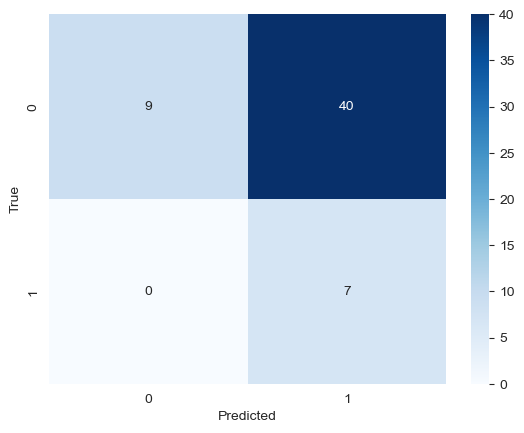

RF

                     Metric      Value
0                  Accuracy   0.535714
1             True Positive   7.000000
2             True Negative  23.000000
3            False Positive  26.000000
4            False Negative   0.000000
5               Sensitivity   1.000000
6               Specificity   0.469388
7    Predictive Value (PPV)   0.212121
8  Negative Predicted Value   1.000000




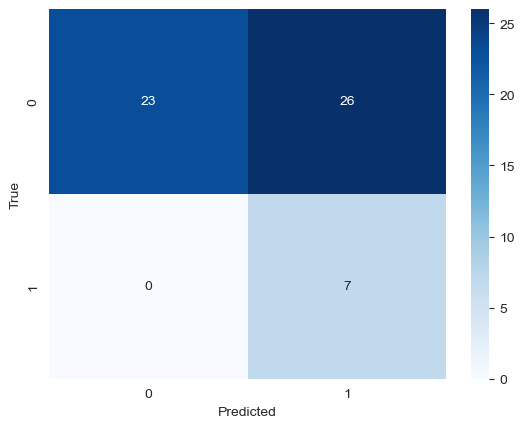

Decision Tree

                     Metric      Value
0                  Accuracy   0.642857
1             True Positive   6.000000
2             True Negative  30.000000
3            False Positive  19.000000
4            False Negative   1.000000
5               Sensitivity   0.857143
6               Specificity   0.612245
7    Predictive Value (PPV)   0.240000
8  Negative Predicted Value   0.967742




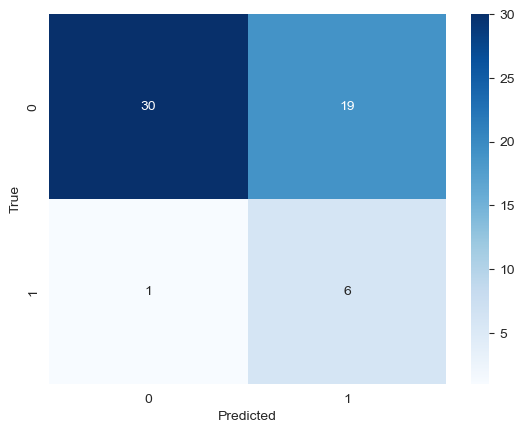

Naive Bayes

                     Metric      Value
0                  Accuracy   0.214286
1             True Positive   7.000000
2             True Negative   5.000000
3            False Positive  44.000000
4            False Negative   0.000000
5               Sensitivity   1.000000
6               Specificity   0.102041
7    Predictive Value (PPV)   0.137255
8  Negative Predicted Value   1.000000




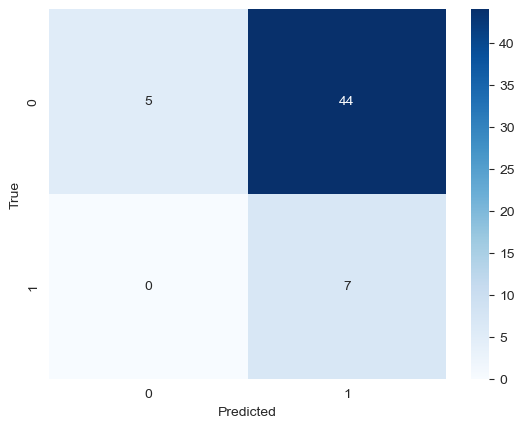

Logistic Regression

                     Metric      Value
0                  Accuracy   0.160714
1             True Positive   7.000000
2             True Negative   2.000000
3            False Positive  47.000000
4            False Negative   0.000000
5               Sensitivity   1.000000
6               Specificity   0.040816
7    Predictive Value (PPV)   0.129630
8  Negative Predicted Value   1.000000




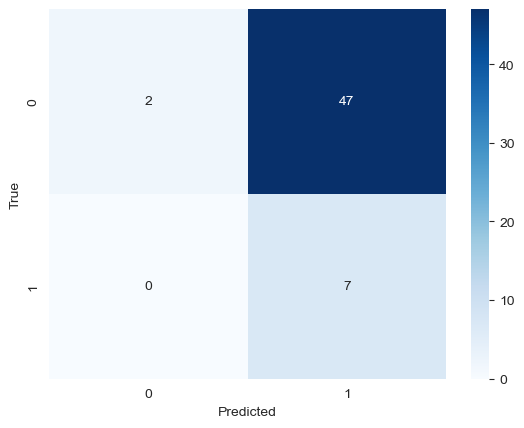

SVM

                     Metric      Value
0                  Accuracy   0.321429
1             True Positive   7.000000
2             True Negative  11.000000
3            False Positive  38.000000
4            False Negative   0.000000
5               Sensitivity   1.000000
6               Specificity   0.224490
7    Predictive Value (PPV)   0.155556
8  Negative Predicted Value   1.000000




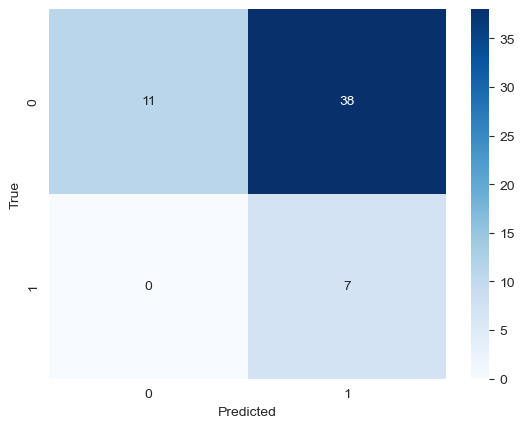

KNN

                     Metric      Value
0                  Accuracy   0.825397
1             True Positive  11.000000
2             True Negative  41.000000
3            False Positive   8.000000
4            False Negative   3.000000
5               Sensitivity   0.785714
6               Specificity   0.836735
7    Predictive Value (PPV)   0.578947
8  Negative Predicted Value   0.931818




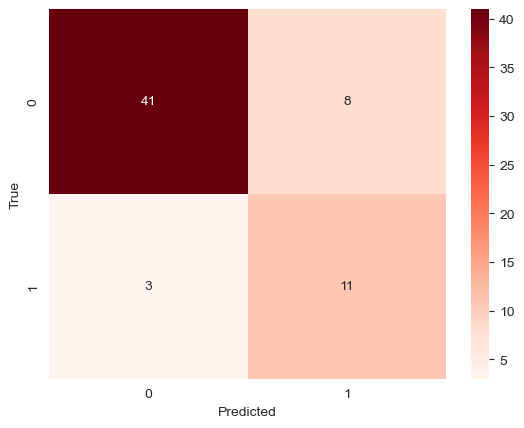

RF

                     Metric      Value
0                  Accuracy   0.825397
1             True Positive  13.000000
2             True Negative  39.000000
3            False Positive  10.000000
4            False Negative   1.000000
5               Sensitivity   0.928571
6               Specificity   0.795918
7    Predictive Value (PPV)   0.565217
8  Negative Predicted Value   0.975000




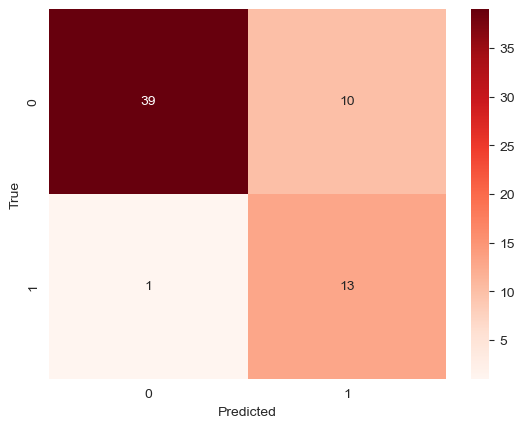

Decision Tree

                     Metric      Value
0                  Accuracy   0.825397
1             True Positive  12.000000
2             True Negative  40.000000
3            False Positive   9.000000
4            False Negative   2.000000
5               Sensitivity   0.857143
6               Specificity   0.816327
7    Predictive Value (PPV)   0.571429
8  Negative Predicted Value   0.952381




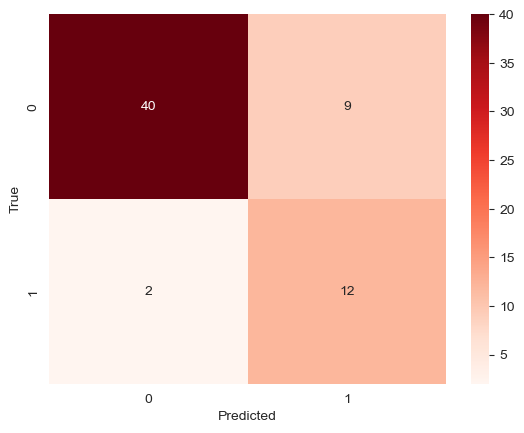

Naive Bayes

                     Metric      Value
0                  Accuracy   0.809524
1             True Positive  13.000000
2             True Negative  38.000000
3            False Positive  11.000000
4            False Negative   1.000000
5               Sensitivity   0.928571
6               Specificity   0.775510
7    Predictive Value (PPV)   0.541667
8  Negative Predicted Value   0.974359




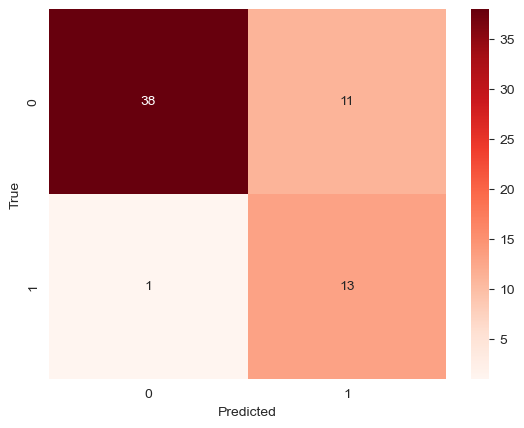

Logistic Regression

                     Metric      Value
0                  Accuracy   0.857143
1             True Positive  12.000000
2             True Negative  42.000000
3            False Positive   7.000000
4            False Negative   2.000000
5               Sensitivity   0.857143
6               Specificity   0.857143
7    Predictive Value (PPV)   0.631579
8  Negative Predicted Value   0.954545




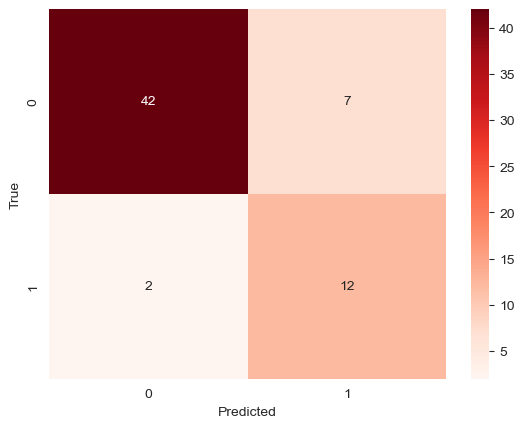

SVM

                     Metric      Value
0                  Accuracy   0.809524
1             True Positive  11.000000
2             True Negative  40.000000
3            False Positive   9.000000
4            False Negative   3.000000
5               Sensitivity   0.785714
6               Specificity   0.816327
7    Predictive Value (PPV)   0.550000
8  Negative Predicted Value   0.930233




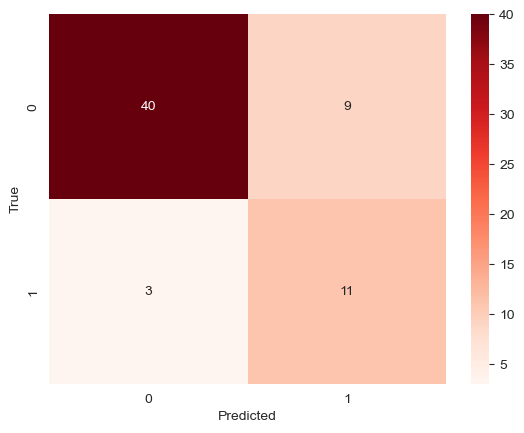

{}

In [201]:
run_ml_algorithms(male_features1,0.3,'id','label','Blues')
run_ml_algorithms(female_features1,0.3,'id','label','Reds')